In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn

import bindingdata

from importlib import reload
reload(biophysnn)

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

## Loading data

In [2]:
binding_data = pd.read_csv("/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data

,chrom,start,end,name,score,strand
0,chr1,16099,16580,all_hnrnpk_rep1_neg_peak_35,81,-
1,chr1,19237,19896,all_hnrnpk_rep1_neg_peak_36,48,-
2,chr1,136471,137136,all_hnrnpk_rep1_neg_peak_37,73,-
3,chr1,186383,187169,all_hnrnpk_rep1_neg_peak_38,54,-
4,chr1,190825,191102,all_hnrnpk_rep1_neg_peak_39,51,-
...,...,...,...,...,...,...
149418,chr9,138179008,138179394,all_hnrnpk_rep1_pos_peak_74674,72,+
149419,chr9,138232102,138232344,all_hnrnpk_rep1_pos_peak_74675,362,+
149420,chr9,138232980,138233211,all_hnrnpk_rep1_pos_peak_74676,254,+
149421,chr9,138276024,138276247,all_hnrnpk_rep1_pos_peak_74677,340,+


In [3]:
unbound = pd.read_csv("unbound_regions.bed.gz", 
                      sep = "\t", 
                      names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
                      index_col = False)
unbound

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,chrom,start,end,name,strand,counts,length
0,chr1,17369,17436,ENSG00000278267.1,-,53,68
1,chr1,135141,135895,ENSG00000268903.1,-,903,755
2,chr1,137682,137965,ENSG00000269981.1,-,1206,284
3,chr1,185217,186383,ENSG00000279457.4,-,295,1397
4,chr1,187169,190825,ENSG00000279457.4,-,295,1397
...,...,...,...,...,...,...,...
126565,chrM,14149,14673,ENSG00000198695.2,-,59390,525
126566,chrM,14674,14742,ENSG00000210194.1,-,598,69
126567,chrM,14747,15887,ENSG00000198727.2,+,247327,1141
126568,chrM,15888,15953,ENSG00000210195.2,+,663,66


In [4]:
unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)
bind_all.iloc[10]

chrom                            chr1
start                          629752
end                            629972
name      all_hnrnpk_rep1_pos_peak_23
score                             246
strand                              +
Name: 74767, dtype: object

In [5]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09493766126042802, 0.1428707751144192)

In [6]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

In [7]:
pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
pwm_names = pwm_dat['names']
pwms = pwm_dat['pwms']

pwms[pwms > 0].min()
log_pwms = np.log(pwms + 1e-4)

# Convert to actual PWM
w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
w_norm = w - w.mean(1,keepdims=True)

w_norm.shape

torch.Size([453, 4, 7])

In [8]:
specific_pwms = w_norm[ np.array([ "HNRNPK" in g for g in pwm_names ]) ]
specific_pwms.shape

torch.Size([5, 4, 7])

In [40]:
perf = {}
for num_chunks in range(1,12):
    print(num_chunks)
    cnn = biophysnn.CNN_1d(use_flipping=False, 
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = num_chunks, 
                           pool_factor = 4, 
                           filter_widths = [11, 7, 7])
    print("Input length", cnn.seq_len)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=8,
                                                                       check_point_filename="checkpoints/cnn/%i.pt" % num_chunks, 
                                                                       verbose = False)
    perf[num_chunks] = np.max(val_aucs)

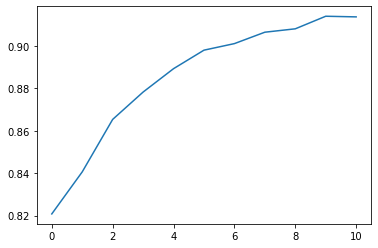

In [37]:
plt.plot(perf.values())

In [39]:
perf.values()

dict_values([0.8207643760358998, 0.8405880586145534, 0.8653253527963398, 0.8782221537639632, 0.8892499523871085, 0.8979777105035043, 0.9010687659137242, 0.9064452856092446, 0.9080424362054823, 0.913971496917465, 0.9136715029197534])

In [ ]:
reload(biophysnn)
reload(bindingdata)
#perf2 = {}
for pool_width in [23,25,27,29,31]: # [3,5,7,9,11,13, 15, 17, 19, 21]:
    print(pool_width)
    cnn = biophysnn.LogConvExpNet(
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = 9, 
                           pool_stride = 4, 
                           pool_width = pool_width,
                           filter_widths = [11, 7, 7] ,
                           pooling= True)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=0,
                                                                       check_point_filename="checkpoints/cnn/log_conv_exp%i.pt" % pool_width, 
                                                                       verbose = False)
    perf2[pool_width] = np.max(val_aucs)

23
Receptive field: 529 Chunk size: 64 Number chunks: 9


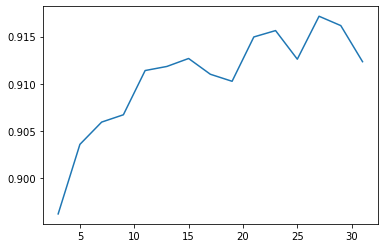

In [15]:
plt.plot(perf2.keys(),perf2.values())

In [23]:
best_pool_width = list(perf2.keys())[np.argmax(list(perf2.values()))] # 27
cnn = biophysnn.LogConvExpNet(
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = 9, 
                           pool_stride = 4, 
                           pool_width = best_pool_width,
                           filter_widths = [11, 7, 7] ,
                           pooling = True)
cnn.seq_len

Receptive field: 613 Chunk size: 64 Number chunks: 9


1189

In [45]:
perf3

{1: 0.7676979961053899,
 2: 0.8526794878900019,
 4: 0.9157489155272509,
 6: 0.9279618262488177,
 8: 0.9274455464933697}

## ExpConvLogConv

In [44]:
reload(biophysnn)
reload(bindingdata)
perf3 = {}
for pool_stride in [1,2,4,6,8,12,16]:
    cnn = biophysnn.LogConvExpNet(
                               nchannels = [4, 16, 16, 16], 
                               n_hidden = 16, 
                               num_chunks = 9, 
                               pool_stride = pool_stride, 
                               pool_width = 27,
                               filter_widths = [11, 7, 7] ,
                               pooling= False)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=8,
                                                                       check_point_filename="checkpoints/cnn/exp_conv_log_conv%i.pt" % pool_stride, 
                                                                       verbose = False)
    perf3[pool_stride] = np.max(val_aucs)

0.541324854612918

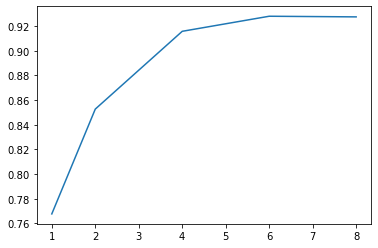

In [46]:
plt.plot(perf3.keys(),perf3.values())

In [53]:
pool_stride = 4
check_point_filename="checkpoints/cnn/exp_conv_log_conv%i.pt" % pool_stride
cnn = biophysnn.LogConvExpNet(
                   nchannels = [4, 16, 16, 16], 
                   n_hidden = 16, 
                   num_chunks = 9, 
                   pool_stride = pool_stride, 
                   pool_width = 27,
                   filter_widths = [11, 7, 7] ,
                   pooling= False)
cnn.load_state_dict(torch.load(check_point_filename))

Receptive field: 613 Chunk size: 64 Number chunks: 9


<All keys matched successfully>

In [62]:
param_dict = dict(cnn.named_parameters())
param_dict.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.2.weight', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.6.weight', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'dense_net.0.weight', 'dense_net.0.bias', 'dense_net.3.weight', 'dense_net.3.bias'])

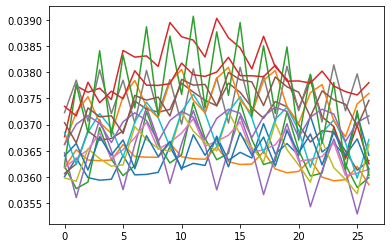

In [76]:
avg_pooler = F.softplus(param_dict['conv_net.2.weight'].data)
for i in range(16): plt.plot(avg_pooler[i,i,:])

So doesn't change much from init. 

In [81]:
aclone = avg_pooler.clone()
for i in range(16): aclone[i,i,:] = 0. 
aclone.max().item()

4.8183457693085074e-05

## Test flipped CNN

1 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
2 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
3 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
4 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
5 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
6 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
7 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
8 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
9 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
10 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive 

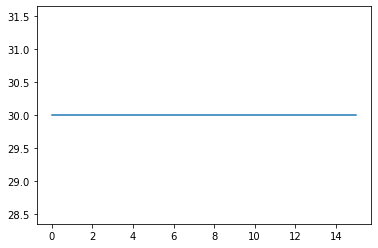

In [16]:
reload(biophysnn)

test_acc_flipped = {}
test_auc_flipped = {}
seq_lens = {}
test_acc_regular = {}
test_auc_regular = {}
for num_filters in range(1,17): 
    print(num_filters, end = " ")
    flipped_cnn = biophysnn.CNN_1d(use_flipping=True, nchannels = [4, num_filters], n_hidden = 16, filter_widths = [10])
    seq_lens[num_filters] = flipped_cnn.seq_len
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(flipped_cnn, train_data, validation_data, genome, verbose = False)
    test_dataset = bindingdata.BedPeaksDataset(test_data, genome, flipped_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_flipped[num_filters], test_auc_flipped[num_filters], _, _, _ = biophysnn.run_one_epoch(test_dataloader, flipped_cnn, None)

    regular_cnn = biophysnn.CNN_1d(use_flipping=False,  nchannels = [4, num_filters], n_hidden = 16, filter_widths = [11])
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(regular_cnn, train_data, validation_data, genome, verbose = False)
    test_dataset = bindingdata.BedPeaksDataset(test_data, genome, regular_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_regular[num_filters], test_auc_regular[num_filters], _, _, _ = biophysnn.run_one_epoch(test_dataloader, regular_cnn, None)
plt.plot(list(seq_lens.values()))

In [20]:
test_auc_flipped_values = np.array(list(test_acc_flipped.values()))
print("%.3f +/- %.3f" % (test_acc_flipped_values.mean(), test_acc_flipped_values.std()))

0.609 +/- 0.006


In [19]:
test_auc_regular_values = np.array(list(test_acc_regular.values()))
print("%.3f +/- %.3f" % (test_acc_regular_values.mean(), test_acc_regular_values.std()))

0.614 +/- 0.010


In [ ]:
test_acc_regular_values

Wow really bad AUCs! Not looking at enough sequence. 

In [25]:
regular_cnn.seq_len

30